# Using USR to score dialogues

In [115]:
import sys
import os
import sys
import os
import json
import emissor as em
from emissor.persistence import ScenarioStorage
from emissor.representation.annotation import AnnotationType, Token, NER
from emissor.representation.container import Index
from emissor.representation.scenario import Modality, ImageSignal, TextSignal, Mention, Annotation, Scenario

src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path)

#### The next utils are needed for the interaction and creating triples and capsules
import chatbots.evaluation as eval
from chatbots.evaluation.dialogue_evaluation_likelihood import USR_MLM
from chatbots.evaluation.dialogue_evaluation_usr import USR_CTX

## Getting the dialogue from an EMISSOR scenario

In [14]:
def get_turns_with_context_from_signals(signals:[], max_context=200):
    triples = []
    context = ""
    target = ""
    cue =""
    for index, signal in enumerate(signals):
        if index == 0:
            target = ''.join(signal.seq)
        else:
            cue = target
            context += " "+target
            target = ''.join(signal.seq)
        if len(context)>max_context:
            context = context[len(context)-max_context:]
        triple = (context, target, cue)
        triples.append(triple)
    return triples

In [19]:
scenario_path = "/Users/piek/PycharmProjects/cltl-chatbots/data"
### The name of your scenario
scenario_id = "2021-11-30-09:08:06"

max_context=300
### Create the scenario folder, the json files and a scenarioStorage and scenario in memory
scenarioStorage = ScenarioStorage(scenario_path)
scenario_ctrl = scenarioStorage.load_scenario(scenario_id)
signals = scenario_ctrl.get_signals(Modality.TEXT)
turns = get_turns_with_context_from_signals(signals, max_context)
print('Nr of turns:', len(turns), ' extracted from scenario: ', scenario_id)

Nr of turns: 62  extracted from scenario:  2021-11-30-09:08:06


## USR Masked Language Model scoring

We use the the Roberta model that was pretrained with the TopicalChat data by the USR team as a model for gettting the averaged token likelihood of the target sentence. The function *sentence_likelihood* also returns the most likley sentence according to the model and the averaged score for the mostly likely tokens. We can thus compare the actual response in a turn with the response that would be generated by the LM.

The LM will return a number of results for the masked token with probability scores. We compare the target token with the results to get the score for the target token. If the target token is not in the results, we set the probability to "0".

You can set the number of results returned by the model. The more results, the more likely the target gets a score, albeit a very low score.

In [74]:
top=20 ### this defines the number results returned by the LM for a masked token that we compare against
model_path_mlm = 'adamlin/usr-topicalchat-roberta_ft'
model_mlm = USR_MLM(path=model_path_mlm, top_results=top)

In [113]:
scores = []
max_scores=[]
odd_scores=[]
odd_max_scores=[]
even_scores=[]
even_max_scores=[]
turn_index =[]
rows =[]
for index, turn in enumerate(turns):
    turn_index.append(index)
    context = turn[0]
    target = turn[1]
    cue=turn[2]
    llh, best_sentence, max_score = model_mlm.sentence_likelihood(context,target)
    row={"Turn": index, "Cue": cue, "Context": context, "System response": target, "MLM response": best_sentence, "System llh":llh, "MLM llh": max_score}
    rows.append(row)
#    print(row)
    scores.append(llh)
    max_scores.append(max_score)

    if index % 2 == 0:
        even_scores.append(llh)
        even_max_scores.append(max_score)
    else:
        odd_scores.append(llh)
        odd_max_scores.append(max_score)

### Obtaining the overall Likelihood score

In [77]:
average_score = sum(scores)/len(scores)
print('\nAverage score:', average_score)

average_max_score = sum(max_scores)/len(max_scores)
print('\nAverage max score:', average_max_score)

average_even_score = sum(even_scores) / len(even_scores)
print('\nAverage even score:', average_even_score)

average_max_even_score = sum(odd_max_scores) / len(even_max_scores)
print('\nAverage max even score:', average_max_score)

average_odd_score = sum(odd_scores) / len(odd_scores)
print('\nAverage odd score:', average_odd_score)

average_max_odd_score = sum(odd_max_scores) / len(odd_max_scores)
print('\nAverage max odd score:', average_max_odd_score)


Average score: 0.4150999247524367

Average max score: 0.702066111717279

Average even score: 0.35726288844792575

Average max even score: 0.702066111717279

Average odd score: 0.47293696105694794

Average max odd score: 0.7624924522745903


### Visualising the dialogue quality

In [112]:
import numpy as np
import matplotlib.pyplot as plt

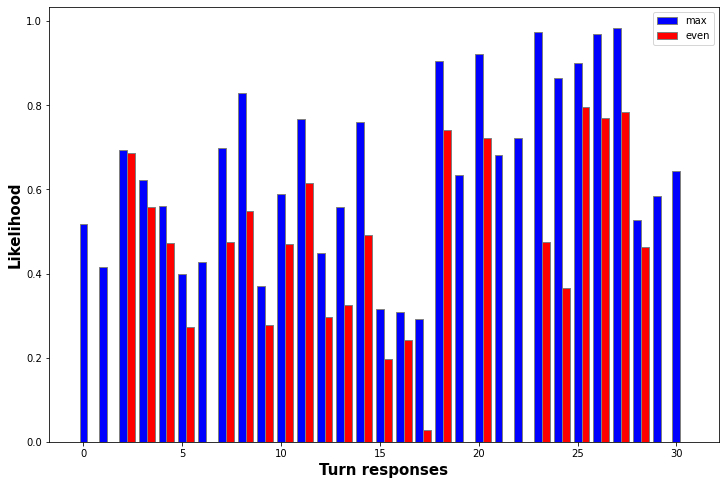

In [79]:
br1 = np.arange(len(even_scores))
br2 = [x + barWidth for x in br1]
barWidth = 0.4
fig = plt.subplots(figsize =(12, 8))

plt.bar(br1, even_max_scores, color="b", width=barWidth, edgecolor="grey", label="max")
plt.bar(br2, even_scores, color="r", width=barWidth, edgecolor="grey", label="even")
plt.xlabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('Likelihood', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

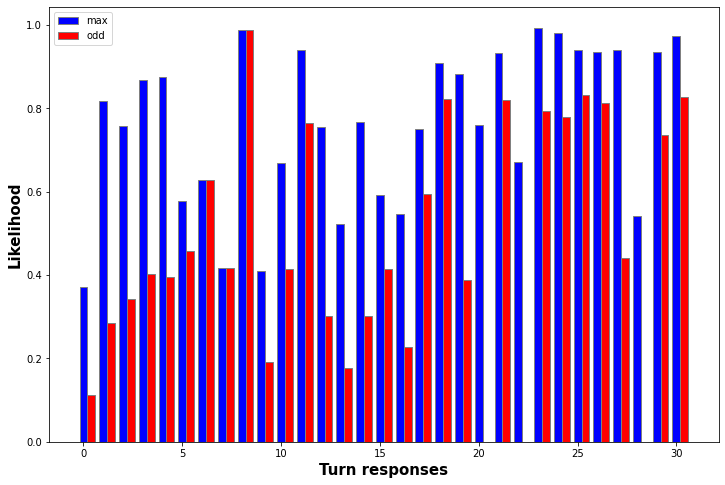

In [80]:
br1 = np.arange(len(odd_scores))
br2 = [x + barWidth for x in br1]

barWidth = 0.4
fig = plt.subplots(figsize =(12, 8))

plt.bar(br1, odd_max_scores, color="b", width=barWidth, edgecolor="grey", label="max")
plt.bar(br2, odd_scores, color="r", width=barWidth, edgecolor="grey", label="odd")
plt.xlabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('Likelihood', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

## USR Context scoring

We first initiliase the models:

In [118]:
model_path = 'adamlin/usr-topicalchat-ctx'
model_ctx = USR_CTX(path=model_path)

model_path = 'adamlin/usr-topicalchat-uk'
model_uk = USR_CTX(path=model_path)

Some weights of the model checkpoint at adamlin/usr-topicalchat-ctx were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at adamlin/usr-topicalchat-uk were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model train

We now apply the models to get the scores and add these to the rows created before using the MLM. We also aggregate the scores for creating a dialogue graph. In this case we do not have a maximum score as a reference.

In [122]:
ctx_odd_scores=[]
uk_odd_scores=[]
ctx_even_scores=[]
uk_even_scores=[]

for index, row in enumerate(rows):
    score_ctx = model_ctx.MCtx(row['Context'], row['System response'])
    score_uk = model_uk.MCtx(row['Context'], row['System response'])
    
    row['USR Context']=score_ctx
    row['USR Use knowledge']=score_uk
        
    if index % 2 == 0:
        ctx_even_scores.append(score_ctx)
        uk_even_scores.append(score_uk)
    else:
        ctx_odd_scores.append(score_ctx)
        uk_odd_scores.append(score_uk)

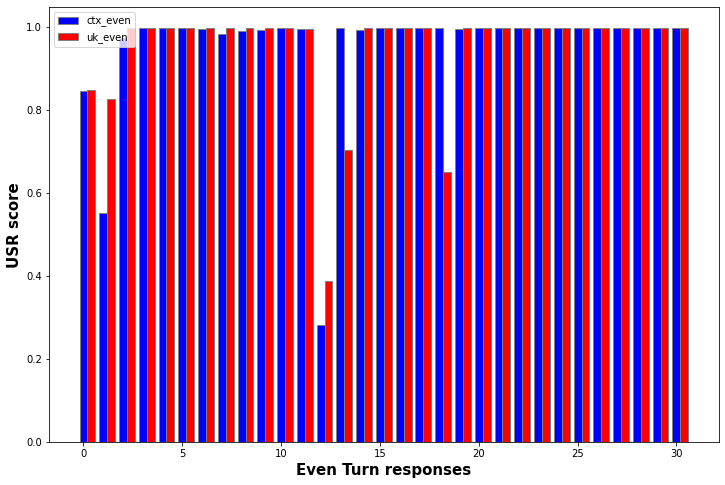

In [124]:
br1 = np.arange(len(ctx_even_scores))
br2 = [x + barWidth for x in br1]
barWidth = 0.4
fig = plt.subplots(figsize =(12, 8))

plt.bar(br1, ctx_even_scores, color="b", width=barWidth, edgecolor="grey", label="ctx_even")
plt.bar(br2, uk_even_scores, color="r", width=barWidth, edgecolor="grey", label="uk_even")
plt.xlabel('Even Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('USR score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

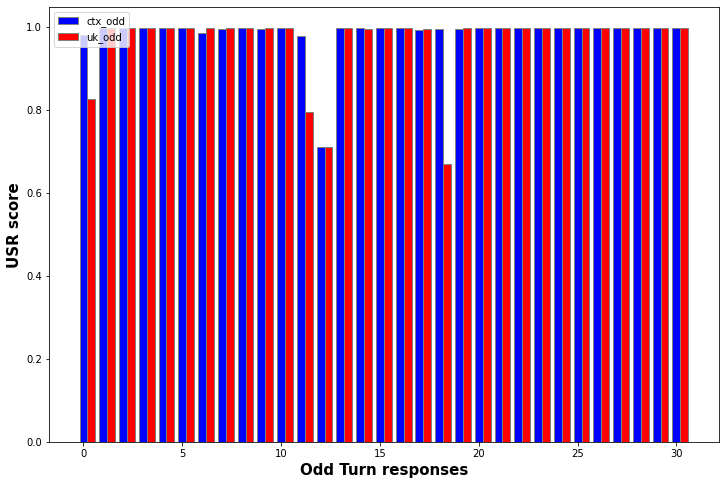

In [125]:
br1 = np.arange(len(ctx_odd_scores))
br2 = [x + barWidth for x in br1]
barWidth = 0.4
fig = plt.subplots(figsize =(12, 8))

plt.bar(br1, ctx_odd_scores, color="b", width=barWidth, edgecolor="grey", label="ctx_odd")
plt.bar(br2, uk_odd_scores, color="r", width=barWidth, edgecolor="grey", label="uk_odd")
plt.xlabel('Odd Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('USR score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

## Saving the results to CSV

In [126]:
column_names = ["Overall Human Rating","Interesting","Engaging","Specific","Relevant","Correct","Semantically Appropriate","Understandable","Fluent"]

In [131]:
import pandas as pd
result_frame = pd.DataFrame(rows)
for annotation in column_names:
    result_frame[annotation]=""
result_frame.head()

,Turn,Cue,Context,System response,MLM response,System llh,MLM llh,USR Context,USR Use knowledge,Overall Human Rating,Interesting,Engaging,Specific,Relevant,Correct,Semantically Appropriate,Understandable,Fluent
0,0,,,Let's chat!,great go,0.000000,0.516952,0.846419,0.847466,,,,,,,,,
1,1,Let's chat!,Let's chat!,"I'm on mobile, but I'll PM you.",maybe not vacation but what see you,0.111369,0.370576,0.980212,0.827033,,,,,,,,,
2,2,"I'm on mobile, but I'll PM you.","Let's chat! I'm on mobile, but I'll PM you.",Interesting,:),0.000000,0.415079,0.550751,0.825669,,,,,,,,,
3,3,Interesting,"Let's chat! I'm on mobile, but I'll PM you. I...","I'm on mobile, but I'll PM you.",'m on mobile but will tell you,0.285604,0.817691,0.998270,0.997318,,,,,,,,,
4,4,"I'm on mobile, but I'll PM you.","Let's chat! I'm on mobile, but I'll PM you. I...",Good to know,good to hear,0.686343,0.694221,0.972708,0.997171,,,,,,,,,


In [132]:
file = scenario_id+".csv"
result_frame.to_csv(file)

## End of notebook